# Classifiez automatiquement des biens de consommation

## Résumé du projet
"Place de marché”, qui souhaite lancer une marketplace e-commerce. Sur la place de marché, des vendeurs proposent des articles à des acheteurs en postant une photo et une description

L'objectif principal de ce projet est d'etudier la faisabilité d'un moteur de classification des articles en différentes catégories des dponnees de l'entreprise Place de marché.

Cela permetra de  rendre l’expérience utilisateur des vendeurs et des acheteurs  la plus fluide possible. En plus, dans l'optique d'un passage à l'échelle, il devient nécessaire d'automatiser cette tâche 


## Librairies

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import copy
import seaborn as sns
import os
import shutil
import re
import random as rn
import cv2
import time
import string
import sklearn.metrics as metrics
import tensorflow as tf

from zipfile import ZipFile
from os import listdir
from pathlib import Path
from functools import reduce
from tqdm import tqdm
from random import shuffle  
from PIL import Image
from numpy import genfromtxt
from wordcloud import WordCloud, STOPWORDS

from yellowbrick.cluster import KElbowVisualizer
from yellowbrick.cluster import InterclusterDistance
from yellowbrick.cluster import intercluster_distance

from sklearn.cluster import KMeans
from sklearn.metrics.cluster import adjusted_rand_score, silhouette_score
from sklearn import cluster
from sklearn.manifold import TSNE
from sklearn import decomposition, preprocessing
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import mean_absolute_error, r2_score,mean_squared_error
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.metrics import accuracy_score,precision_score,recall_score,roc_curve,roc_auc_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay,plot_confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split,KFold, GridSearchCV

from keras.preprocessing.image import ImageDataGenerator
from keras import backend as K
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import ReduceLROnPlateau
from keras.layers import Dropout, Flatten,Activation
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from keras.applications.vgg16 import VGG16
from keras.applications.xception import Xception

from tensorflow.keras.optimizers import Adam, SGD , Adagrad,Adadelta,RMSprop# - Works
from tensorflow.keras.utils import to_categorical

pd.set_option("display.precision", 2)          
pd.set_option("display.max.columns", None)    
pd.set_option("display.max.rows", None)

import warnings
warnings.simplefilter(action='ignore', category=Warning)

In [2]:
rstate=10
var_explained=0.75
seed = 10

## Données

In [3]:
dir_data = Path('../../DATA/P6') 
dir_fig  = Path('../../FIGURE/P6')
work_dir=os.getcwd()
CHECK_FOLDER  = Path('../../DATA/P6/Flipkart') 
CHECK_FOLDER_CNN = Path('../../DATA/P6/DATA_KAGGLE/Flipkart') 
img_path = Path(str(CHECK_FOLDER) + str('/Images/'))
desc_data=str(dir_data)+'/df_clean.csv'

In [4]:
name_img =[]

# Boucle sur les images
for image in listdir(img_path):
    name_img.append(image)

data = pd.DataFrame()
data["image"] = name_img
le = preprocessing.LabelEncoder()
data["label"] = le.fit_transform(data["image"])

df =pd.read_csv(desc_data)
data_merged = pd.merge(
    data, df, left_on='image', right_on='image')



### Transfert learning avec VGG16 

#### Préparation des données

In [5]:
base_dir = '/home/yonss/Data_Scientist/DATA/P6/DATA_KAGGLE/Flipkart/Images'
class_name=data_merged['Category_0'].unique()


if os.path.exists(Path(str(base_dir)+'/'+'baby_care')):
    print('Classes already created')
    
else:
    
    for knx in class_name:
        destination=Path(str(base_dir)+'/'+knx)
        print(knx)
        if not os.path.exists(destination):
            os.makedirs(destination)
            print('create dir')
        subset=data_merged.loc[data_merged['Category_0'] == knx]
        for tnx in subset.index:
            if subset['Category_0'][tnx]==knx:
                shutil.move(Path(str(base_dir)+'/'+subset['image'][tnx]), destination)


Classes already created


In [6]:
def assign_label(img,flower_type):
    return flower_type

def make_train_data(flower_type,DIR,cat):
    for img in tqdm(os.listdir(DIR)):
        label=assign_label(img,flower_type)
        catlab=assign_label(img,cat)
        
        path = os.path.join(DIR,img)
        
        img = cv2.imread(path,cv2.IMREAD_COLOR)

        # convert all picture to the same size
        img = cv2.resize(img,IMAGE_SIZE) 

        
        X.append(np.array(img))
        Z.append(str(label))
        ZZ.append(catlab)


In [7]:
IMAGE_SIZE=(155, 155)
class_name_dir={'kitchen_and_dining':Path(str(base_dir)+'/'+'kitchen_and_dining'), 
                'home_furnishing':Path(str(base_dir)+'/'+'home_furnishing') ,
                'home_decor_and_festive_needs':Path(str(base_dir)+'/'+'home_decor_and_festive_needs'), 
                'computers':Path(str(base_dir)+'/'+'computers'), 'watches':Path(str(base_dir)+'/'+'watches'),
                'beauty_and_personal_care':Path(str(base_dir)+'/'+'beauty_and_personal_care'), 
                'baby_care':Path(str(base_dir)+'/'+'baby_care')}
lab_category = {'home_furnishing':0, 'baby_care':1,'watches':2,'home_decor_and_festive_needs':3,\
                'kitchen_and_dining':4,'beauty_and_personal_care':5,'computers':6}

In [8]:
X =[]
Z =[]
ZZ=[]
for ks in class_name_dir:
    print(class_name_dir[ks])
    make_train_data(ks,class_name_dir[ks],lab_category[ks])

/home/yonss/Data_Scientist/DATA/P6/DATA_KAGGLE/Flipkart/Images/kitchen_and_dining


100%|████████████████████████████████████████| 150/150 [00:03<00:00, 44.66it/s]


/home/yonss/Data_Scientist/DATA/P6/DATA_KAGGLE/Flipkart/Images/home_furnishing


100%|████████████████████████████████████████| 150/150 [00:05<00:00, 28.80it/s]


/home/yonss/Data_Scientist/DATA/P6/DATA_KAGGLE/Flipkart/Images/home_decor_and_festive_needs


100%|████████████████████████████████████████| 150/150 [00:02<00:00, 53.19it/s]


/home/yonss/Data_Scientist/DATA/P6/DATA_KAGGLE/Flipkart/Images/computers


100%|███████████████████████████████████████| 150/150 [00:01<00:00, 104.21it/s]


/home/yonss/Data_Scientist/DATA/P6/DATA_KAGGLE/Flipkart/Images/watches


100%|████████████████████████████████████████| 150/150 [00:01<00:00, 88.93it/s]


/home/yonss/Data_Scientist/DATA/P6/DATA_KAGGLE/Flipkart/Images/beauty_and_personal_care


100%|████████████████████████████████████████| 150/150 [00:02<00:00, 73.10it/s]


/home/yonss/Data_Scientist/DATA/P6/DATA_KAGGLE/Flipkart/Images/baby_care


100%|████████████████████████████████████████| 150/150 [00:03<00:00, 47.24it/s]


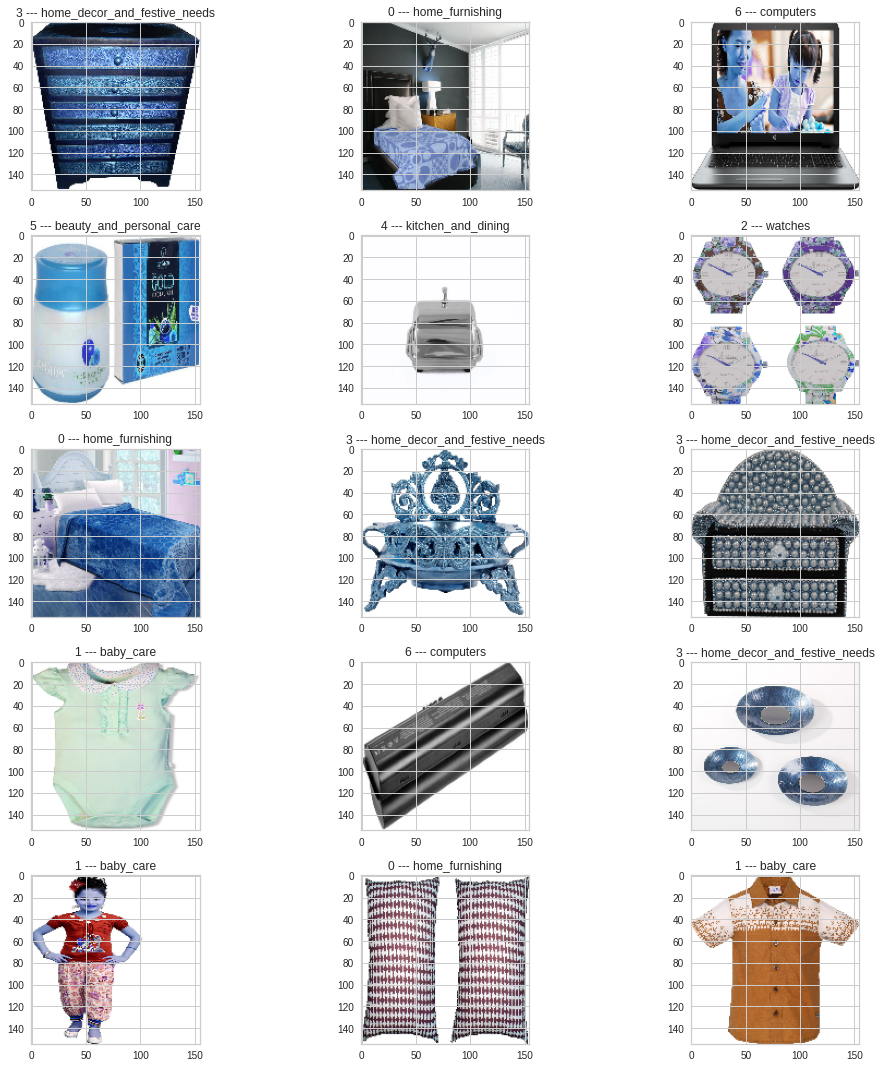

In [9]:
fig,ax=plt.subplots(5,3)
fig.set_size_inches(15,15)
for i in range(5):
    for j in range (3):
        l=rn.randint(0,len(Z))
        ax[i,j].imshow(X[l])
        ax[i,j].set_title(str(ZZ[l]) + ' --- '+Z[l])
        
plt.tight_layout()
        

In [10]:
Y=to_categorical(ZZ,len(class_name))
X=np.array(X)

In [11]:
x_train,x_test,y_train,y_test=train_test_split(X,Y,test_size=0.25,random_state=42) #Splitting into Training and Validation Sets¶


In [12]:
np.random.seed(42)
rn.seed(42)
tf.random.set_seed(seed)

#### Spécification du modèle de base
L'apprentissage par transfert consiste à utiliser un modèle pré-entraîné sur une autre tâche pour votre propre tâche. 
Pour notre tache, nous utilisons le modèle VGG16 de la bibliothèque Keras comme le modèle de base.


Etapes:
    1) Importer le module VGG16 de la bibliothèque Keras.
    2) Spécifier si on utilise les couches entièrement connectées du module VGG16 ou nos propres couches. 
      on utilise nos propres couches ('include_top' comme 'False').
    3) Spécifier les poids à utiliser par le modèle.
    Puisque je veux qu'il utilise les poids sur lesquels il a été entraîné dans la compétition ImageNet, j'ai chargé les poids à partir du fichier correspondant. Vous pouvez spécifier directement l'argument des poids comme 'imagenet' dans VGG16( ) mais cela n'a pas fonctionné dans mon cas donc j'ai dû charger explicitement les poids depuis un fichier.
    4) Spécifier la forme de l'entrée que le modèle doit attendre et aussi le type de 'pooling'.


In [13]:
base_model=VGG16(include_top=False, weights='imagenet',input_shape=(155, 155,3), pooling='avg')

2021-12-17 17:31:33.882458: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-17 17:31:33.918196: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-17 17:31:33.918525: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-17 17:31:33.919398: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

In [14]:
base_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 155, 155, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 155, 155, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 155, 155, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 77, 77, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 77, 77, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 77, 77, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 38, 38, 128)       0     

In [15]:
model=Sequential()
model.add(base_model)
model.add(Dense(len(class_name)*3,activation='relu'))
model.add(Dense(len(class_name),activation='softmax'))

In [16]:
datagen = ImageDataGenerator( featurewise_center=False, samplewise_center=False,
    featurewise_std_normalization=False, samplewise_std_normalization=False,
    zca_whitening=False, zca_epsilon=1e-06, rotation_range=0, width_shift_range=0.0,
    height_shift_range=0.0, brightness_range=None, shear_range=0.0, zoom_range=0.0,
    channel_shift_range=0.0, fill_mode='nearest', cval=0.0,
    horizontal_flip=False, vertical_flip=False, rescale=None,
    preprocessing_function=None, data_format=None, validation_split=0.0, dtype=None


)  # 

datagen.fit(x_train)

In [17]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 512)               14714688  
                                                                 
 dense (Dense)               (None, 21)                10773     
                                                                 
 dense_1 (Dense)             (None, 7)                 154       
                                                                 
Total params: 14,725,615
Trainable params: 14,725,615
Non-trainable params: 0
_________________________________________________________________


In [18]:
adamval=5e-4
base_model.trainable=False # setting the VGG model to be untrainable.
model.compile(optimizer=Adam(lr=adamval),loss='categorical_crossentropy',metrics=['accuracy'])

In [19]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 512)               14714688  
                                                                 
 dense (Dense)               (None, 21)                10773     
                                                                 
 dense_1 (Dense)             (None, 7)                 154       
                                                                 
Total params: 14,725,615
Trainable params: 10,927
Non-trainable params: 14,714,688
_________________________________________________________________


In [20]:
from keras.callbacks import ModelCheckpoint, EarlyStopping
red_lr=ReduceLROnPlateau(monitor='val_loss', factor=0.2,patience=2, min_lr=0.000001)
es = EarlyStopping(monitor='val_accuracy', mode='max',min_delta=0.005,patience=3)

epochs=50
batch_size=64
History = model.fit_generator(datagen.flow(x_train,y_train, batch_size=batch_size),
                                  epochs = epochs, validation_data = (x_test,y_test),
                                  verbose = 1,steps_per_epoch=None, 
                                  callbacks=[red_lr,es])


Epoch 1/50


2021-12-17 17:31:36.679929: I tensorflow/stream_executor/cuda/cuda_dnn.cc:366] Loaded cuDNN version 8301
2021-12-17 17:31:37.427844: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2021-12-17 17:31:37.516103: W tensorflow/core/common_runtime/bfc_allocator.cc:275] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.03GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.
2021-12-17 17:31:37.516164: W tensorflow/core/common_runtime/bfc_allocator.cc:275] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.03GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.
2021-12-17 17:31:37.911413: W tensorflow/core/common_runtime/bfc_allocator.cc:275] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.3

13/13 [==============================] - 15s 776ms/step - loss: 12.1126 - accuracy: 0.1919 - val_loss: 8.8950 - val_accuracy: 0.2319 - lr: 5.0000e-04
Epoch 2/50
13/13 [==============================] - 4s 315ms/step - loss: 6.0838 - accuracy: 0.3011 - val_loss: 5.4250 - val_accuracy: 0.3270 - lr: 5.0000e-04
Epoch 3/50
13/13 [==============================] - 4s 315ms/step - loss: 3.5375 - accuracy: 0.4333 - val_loss: 3.9938 - val_accuracy: 0.4106 - lr: 5.0000e-04
Epoch 4/50
13/13 [==============================] - 4s 315ms/step - loss: 2.5209 - accuracy: 0.5032 - val_loss: 3.3529 - val_accuracy: 0.4487 - lr: 5.0000e-04
Epoch 5/50
13/13 [==============================] - 4s 317ms/step - loss: 1.9602 - accuracy: 0.5667 - val_loss: 2.9375 - val_accuracy: 0.4639 - lr: 5.0000e-04
Epoch 6/50
13/13 [==============================] - 4s 315ms/step - loss: 1.6313 - accuracy: 0.6125 - val_loss: 2.6814 - val_accuracy: 0.4829 - lr: 5.0000e-04
Epoch 7/50
13/13 [==============================] - 4s 

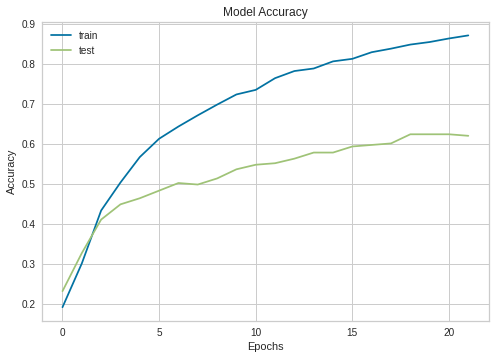

In [21]:
plt.plot(History.history['accuracy'])
plt.plot(History.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'test'])
plt.show()

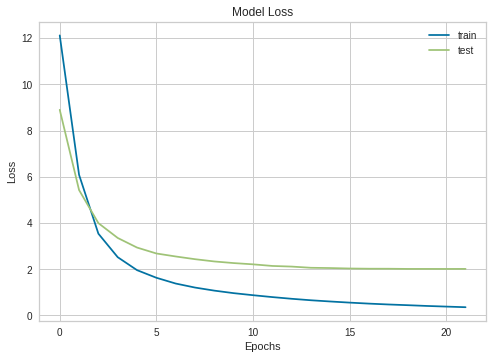

In [22]:
plt.plot(History.history['loss'])
plt.plot(History.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'test'])
plt.show()

### Visualizing Predictons on the Validation Set

Val Accuracy = 0.62


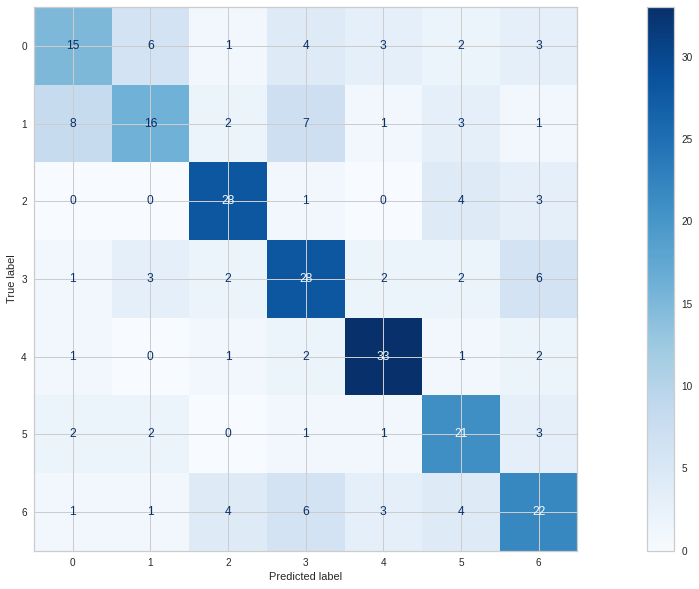

In [23]:
ytest=np.argmax(y_test, axis=1)
# validate on val set
predictions = model.predict(x_test)
PP=np.argmax(predictions, axis=1)
accuracy = accuracy_score(ytest, PP)

print('Val Accuracy = %.2f' % accuracy)

confusion_mtx = confusion_matrix(ytest, PP) 
f, (ax1) = plt.subplots(1,1, figsize=(25,10))
cm_display = ConfusionMatrixDisplay(confusion_mtx ).plot(ax=ax1,cmap=plt.cm.Blues)


# trainable

In [24]:
for i in range (len(base_model.layers)):
    print (i,base_model.layers[i]) 
for layer in base_model.layers[15:]:
    layer.trainable=True
for layer in base_model.layers[0:15]:
    layer.trainable=False

0 <keras.engine.input_layer.InputLayer object at 0x7f79317f4a30>
1 <keras.layers.convolutional.Conv2D object at 0x7f79317af280>
2 <keras.layers.convolutional.Conv2D object at 0x7f79317af880>
3 <keras.layers.pooling.MaxPooling2D object at 0x7f79306be4c0>
4 <keras.layers.convolutional.Conv2D object at 0x7f79302331c0>
5 <keras.layers.convolutional.Conv2D object at 0x7f79306beee0>
6 <keras.layers.pooling.MaxPooling2D object at 0x7f793023b5b0>
7 <keras.layers.convolutional.Conv2D object at 0x7f79317afaf0>
8 <keras.layers.convolutional.Conv2D object at 0x7f793023feb0>
9 <keras.layers.convolutional.Conv2D object at 0x7f79306bebb0>
10 <keras.layers.pooling.MaxPooling2D object at 0x7f793024aaf0>
11 <keras.layers.convolutional.Conv2D object at 0x7f793024f0d0>
12 <keras.layers.convolutional.Conv2D object at 0x7f793024aeb0>
13 <keras.layers.convolutional.Conv2D object at 0x7f79302574c0>
14 <keras.layers.pooling.MaxPooling2D object at 0x7f7930252f10>
15 <keras.layers.convolutional.Conv2D object at 

In [25]:
model.compile(optimizer=Adam(lr=adamval/10),loss='categorical_crossentropy',metrics=['accuracy'])

History = model.fit_generator(datagen.flow(x_train,y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = (x_test,y_test),
                              verbose = 1,steps_per_epoch=None, 
                              callbacks=[red_lr,es])


Epoch 1/50
13/13 [==============================] - 5s 342ms/step - loss: 0.3416 - accuracy: 0.8742 - val_loss: 2.0218 - val_accuracy: 0.6274 - lr: 5.0000e-05
Epoch 2/50
13/13 [==============================] - 4s 319ms/step - loss: 0.3329 - accuracy: 0.8780 - val_loss: 2.0182 - val_accuracy: 0.6312 - lr: 5.0000e-05
Epoch 3/50
13/13 [==============================] - 4s 320ms/step - loss: 0.3248 - accuracy: 0.8831 - val_loss: 2.0189 - val_accuracy: 0.6312 - lr: 5.0000e-05
Epoch 4/50
13/13 [==============================] - 4s 329ms/step - loss: 0.3183 - accuracy: 0.8844 - val_loss: 2.0204 - val_accuracy: 0.6350 - lr: 5.0000e-05
Epoch 5/50
13/13 [==============================] - 4s 317ms/step - loss: 0.3133 - accuracy: 0.8856 - val_loss: 2.0204 - val_accuracy: 0.6350 - lr: 1.0000e-05
Epoch 6/50
13/13 [==============================] - 4s 317ms/step - loss: 0.3120 - accuracy: 0.8869 - val_loss: 2.0207 - val_accuracy: 0.6350 - lr: 1.0000e-05
Epoch 7/50
13/13 [============================

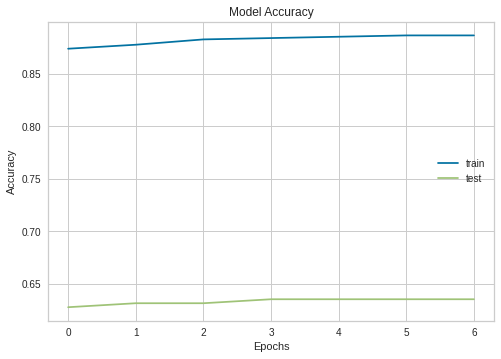

In [26]:
plt.plot(History.history['accuracy'])
plt.plot(History.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'test'])
plt.show()

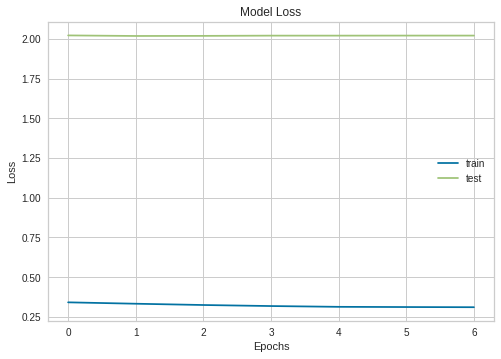

In [27]:
plt.plot(History.history['loss'])
plt.plot(History.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'test'])
plt.show()

Val Accuracy = 0.63


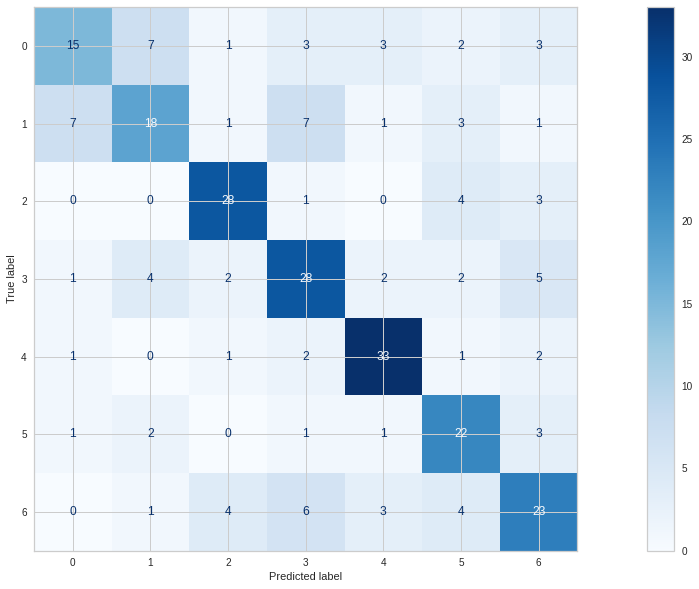

In [28]:
ytest=np.argmax(y_test, axis=1)
# validate on val set
predictions = model.predict(x_test)
PP=np.argmax(predictions, axis=1)
accuracy = accuracy_score(ytest, PP)

print('Val Accuracy = %.2f' % accuracy)

confusion_mtx = confusion_matrix(ytest, PP) 
f, (ax1) = plt.subplots(1,1, figsize=(25,10))
cm_display = ConfusionMatrixDisplay(confusion_mtx ).plot(ax=ax1,cmap=plt.cm.Blues)


In [29]:
predictions_pd=pd.DataFrame(PP)
predictions_pd=predictions_pd.rename(columns={0: 'Pred'})
YTEST_pd=pd.DataFrame(ytest)
YTEST_pd=YTEST_pd.rename(columns={0: 'True'})

# faire pie


5. Conclusions

This project was a combination of CNN model classification problem (to predict wheter the subject has brain tumor or not) & Computer Vision problem (to automate the process of brain cropping from MRI scans). The final accuracy is much higher than 50% baseline (random guess). However, it could be increased by larger number of train images or through model hyperparameters tuning.
